In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Collecte de données




In [ ]:
import pandas as pd
import nltk

In [ ]:
path="/content/drive/MyDrive/dataset/IMDB Dataset.csv"
data = pd.read_csv(path, encoding='latin1')


In [ ]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# Afficher le nombre de lignes du DataFrame
nombre_de_lignes = data.shape[0]
print("Nombre de lignes du DataFrame :", nombre_de_lignes)


Nombre de lignes du DataFrame : 50000


In [ ]:
import pandas as pd

# Supprimer les dernières n lignes
n =44000  # Nombre de dernières lignes à supprimer
data.drop(data.tail(n).index, inplace=True)

In [ ]:
# Afficher le nombre de lignes du DataFrame
nombre_de_lignes = data.shape[0]
print("Nombre de lignes du DataFrame :", nombre_de_lignes)


Nombre de lignes du DataFrame : 6000


In [ ]:
data.columns

Index(['review', 'sentiment'], dtype='object')

In [ ]:
import pandas as pd
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import spacy

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


#Présentation des données avec word2vec sans PRETRAITEMENT de données


In [ ]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np

# Données textuelles (supposons que 'data' est votre DataFrame et 'review' la colonne de textes)
textes = data['review'].apply(lambda x: x.split())  # Séparation des mots sans tokenization

# Générer les embeddings Word2Vec
w2v_model = Word2Vec(sentences=textes, vector_size=100, window=5, min_count=1, workers=4)

# Normaliser les vecteurs de mots pour qu'ils soient positifs
word_vectors = w2v_model.wv
vectors = np.array([word_vectors[word] for word in word_vectors.index_to_key])
vectors_normalized = (vectors - vectors.min()) / (vectors.max() - vectors.min())

# Mettre à jour les vecteurs dans le modèle avec les vecteurs normalisés
for i, word in enumerate(word_vectors.index_to_key):
    word_vectors[word] = vectors_normalized[i]

# Fonction pour transformer un texte en vecteur Word2Vec moyenné
def text_to_vector(text):
    words = text.split()
    valid_words = [word for word in words if word in word_vectors]
    if not valid_words:
        return np.zeros(w2v_model.vector_size)
    word_vecs = np.array([word_vectors[word] for word in valid_words])
    return word_vecs.mean(axis=0)

# Transformer toutes les critiques en vecteurs
data['word2vec'] = data['review'].apply(text_to_vector)

# Afficher les premières lignes du DataFrame avec les vecteurs Word2Vec
print(data.head())


#Modéle Nu-Support Vector Classification(20% test + 80%entrai)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import NuSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Diviser les données en ensembles d'entraînement et de test
X = data['review'].apply(text_to_vector)
y = data['sentiment']  # Les étiquettes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Convertir les listes de vecteurs Word2Vec en tableaux NumPy
X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())
y_train = np.array(y_train)
y_test = np.array(y_test)

# Entraîner le modèle NuSVC
model = NuSVC(probability=True)
model.fit(X_train, y_train)

# Prédictions du modèle sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Affichage des résultats
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.7316666666666667
Precision: 0.7330444488898892
Recall: 0.7316666666666667
F1-score: 0.7317680550616407


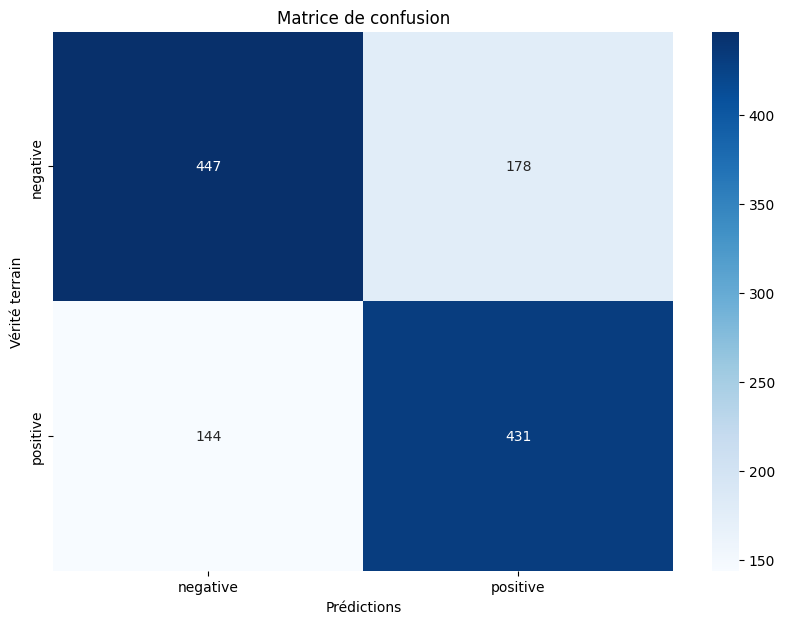

In [ ]:
from sklearn.metrics import  confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion')
plt.show()

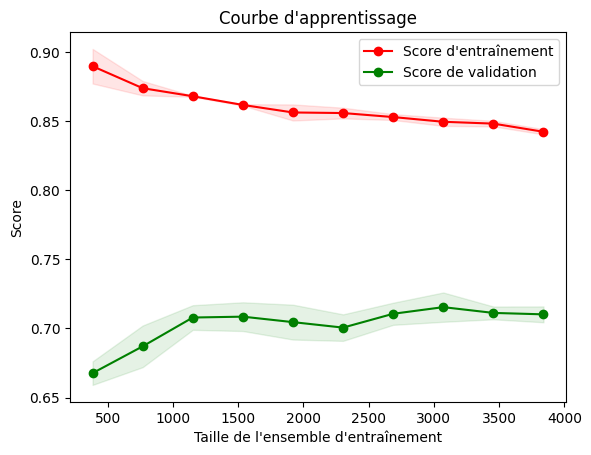

In [ ]:
from sklearn.model_selection import train_test_split, learning_curve
import matplotlib.pyplot as plt

# Tracer la courbe d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calculer les moyennes et les écarts-types des scores d'apprentissage
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validation")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Score")
plt.title("Courbe d'apprentissage")
plt.legend(loc="best")
plt.show()

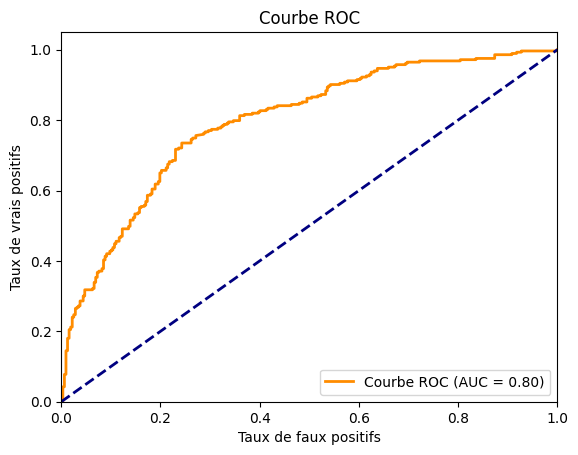

In [ ]:
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score


# Calculer les probabilités pour la courbe ROC
y_score = model.predict_proba(X_test)[:, 1]  # Probabilités de la classe positive

# Calculer la courbe ROC et l'AUC
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=model.classes_[1])
roc_auc = roc_auc_score(y_test, y_score)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Ligne diagonale pour une performance aléatoire
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

#Modéle Nu-Support Vector Classification(10% test + 90%entrai)

In [ ]:
# Diviser les données en ensembles d'entraînement et de test
X = data['review'].apply(text_to_vector)
y = data['sentiment']  # Les étiquettes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# Convertir les listes de vecteurs Word2Vec en tableaux NumPy
X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())
y_train = np.array(y_train)
y_test = np.array(y_test)

# Entraîner le modèle NuSVC
model = NuSVC(probability=True)
model.fit(X_train, y_train)

# Prédictions du modèle sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Affichage des résultats
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


In [ ]:
from sklearn.metrics import  confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion')
plt.show()

In [ ]:
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score


# Calculer les probabilités pour la courbe ROC
y_score = model.predict_proba(X_test)[:, 1]  # Probabilités de la classe positive

# Calculer la courbe ROC et l'AUC
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=model.classes_[1])
roc_auc = roc_auc_score(y_test, y_score)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Ligne diagonale pour une performance aléatoire
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, learning_curve
import matplotlib.pyplot as plt

# Tracer la courbe d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calculer les moyennes et les écarts-types des scores d'apprentissage
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validation")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Score")
plt.title("Courbe d'apprentissage")
plt.legend(loc="best")
plt.show()

#Modéle Nu-Support Vector Classification(30% test + 70%entrai)

In [ ]:

# Diviser les données en ensembles d'entraînement et de test
X = tfidf_df.values  # Les vecteurs TF-IDF
y = data['sentiment']  # Les étiquettes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraîner le modèle NuSVC
model = NuSVC()
model.fit(X_train, y_train)

# Prédictions du modèle sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Affichage des résultats
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.871
Precision: 0.8722782827901465
Recall: 0.871
F1-score: 0.8708340522698957


#Modéle Nu-Support Vector Classification(40% test + 60%entrai)

In [ ]:
# Diviser les données en ensembles d'entraînement et de test
X = tfidf_df.values  # Les vecteurs TF-IDF
y = data['sentiment']  # Les étiquettes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Entraîner le modèle NuSVC
model = NuSVC()
model.fit(X_train, y_train)

# Prédictions du modèle sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Affichage des résultats
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.8655
Precision: 0.8667018175639712
Recall: 0.8655
F1-score: 0.8654208791076864


#Modéle Multinomial Naive Bayes(20% test + 80%entrai)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from sklearn.naive_bayes import MultinomialNB

# Les données textuelles
X = tfidf_df.values
# Les étiquettes
y = data['sentiment']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)

# Prédictions du modèle sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Affichage des résultats
print("Accuracy:", accuracy)
print("Précision:", precision)
print("Rappel:", recall)
print("Score F1:", f1)


Accuracy: 0.8516666666666667
Précision: 0.8556115231011298
Rappel: 0.8516666666666667
Score F1: 0.8515484729215207


#Modéle Multinomial Naive Bayes(10% test + 90%entrai)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.corpus import stopwords
import pandas as pd


# Les données textuelles
X = tfidf_df.values

# Les étiquettes
y = data['sentiment']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Entraîner le modèle MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)

# Prédictions du modèle sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Affichage des résultats
print("Accuracy:", accuracy)
print("Précision:", precision)
print("Rappel:", recall)
print("Score F1:", f1)


Accuracy: 0.8577777777777778
Précision: 0.8609989461712628
Rappel: 0.8577777777777778
Score F1: 0.8578578578578578


#Modéle Multinomial Naive Bayes(30% test + 70%entrai)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.corpus import stopwords
import pandas as pd


# Les données textuelles
X = tfidf_df.values

# Les étiquettes
y = data['sentiment']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraîner le modèle MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)

# Prédictions du modèle sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Affichage des résultats
print("Accuracy:", accuracy)
print("Précision:", precision)
print("Rappel:", recall)
print("Score F1:", f1)


Accuracy: 0.8540740740740741
Précision: 0.8577520709458913
Rappel: 0.8540740740740741
Score F1: 0.8537946988441439


#Modéle Multinomial Naive Bayes(40% test + 60%entrai)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.corpus import stopwords
import pandas as pd

# Les données textuelles
X = tfidf_df.values

# Les étiquettes
y = data['sentiment']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Entraîner le modèle MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)

# Prédictions du modèle sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Affichage des résultats
print("Accuracy:", accuracy)
print("Précision:", precision)
print("Rappel:", recall)
print("Score F1:", f1)


Accuracy: 0.8527777777777777
Précision: 0.8553722648479681
Rappel: 0.8527777777777777
Score F1: 0.8525043579775521



#Modéle Logistic Regression(20% test + 80%entrai)


In [ ]:

from sklearn.linear_model import LogisticRegression

# Les données textuelles
X = tfidf_df.values
# Les étiquettes
y = data['sentiment']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle de régression logistique
model = LogisticRegression()
model.fit(X_train, y_train)

# Prédictions du modèle sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Affichage des résultats
print("accuracy:", accuracy)
print("Précision:", precision)
print("Rappel:", recall)
print("Score F1:", f1)


accuracy: 0.8822222222222222
Précision: 0.8823240454076369
Rappel: 0.8822222222222222
Score F1: 0.8821639452416296


#Modéle Logistic Regression(10% test + 90%entrai)

In [ ]:

from sklearn.linear_model import LogisticRegression

# Les données textuelles
X = tfidf_df.values
# Les étiquettes
y = data['sentiment']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Entraîner le modèle de régression logistique
model = LogisticRegression()
model.fit(X_train, y_train)

# Prédictions du modèle sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Affichage des résultats
print("accuracy:", accuracy)
print("Précision:", precision)
print("Rappel:", recall)
print("Score F1:", f1)


accuracy: 0.8688888888888889
Précision: 0.8688759137617441
Rappel: 0.8688888888888889
Score F1: 0.8688134700437646


#Modéle Logistic Regression(30% test + 70%entrai)

In [ ]:

from sklearn.linear_model import LogisticRegression
# Les données textuelles
X = tfidf_df.values
# Les étiquettes
y = data['sentiment']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraîner le modèle de régression logistique
model = LogisticRegression()
model.fit(X_train, y_train)

# Prédictions du modèle sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Affichage des résultats
print("accuracy:", accuracy)
print("Précision:", precision)
print("Rappel:", recall)
print("Score F1:", f1)


accuracy: 0.8748148148148148
Précision: 0.8750445858076007
Rappel: 0.8748148148148148
Score F1: 0.8747739893229296


#Modéle Logistic Regression(40% test + 60%entrai)

In [ ]:

from sklearn.linear_model import LogisticRegression

# Les données textuelles
X = tfidf_df.values
# Les étiquettes
y = data['sentiment']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Entraîner le modèle de régression logistique
model = LogisticRegression()
model.fit(X_train, y_train)

# Prédictions du modèle sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Affichage des résultats
print("accuracy:", accuracy)
print("Précision:", precision)
print("Rappel:", recall)
print("Score F1:", f1)


accuracy: 0.8658333333333333
Précision: 0.8665789728682171
Rappel: 0.8658333333333333
Score F1: 0.8657670566255453


#Modéle Complement Naive Bayes(20% test + 80%entrai)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB

# Les données textuelles
X = tfidf_df.values
# Les étiquettes
y = data['sentiment']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle Complement Naive Bayes
model = ComplementNB()
model.fit(X_train, y_train)

# Prédictions du modèle sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Affichage des résultats
print("accuracy:", accuracy)
print("Précision:", precision)
print("Rappel:", recall)
print("Score F1:", f1)


accuracy: 0.8516666666666667
Précision: 0.8556115231011298
Rappel: 0.8516666666666667
Score F1: 0.8515484729215207


#Modéle Complement Naive Bayes(10% test + 90%entrai)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB

# Les données textuelles
X = tfidf_df.values
# Les étiquettes
y = data['sentiment']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Entraîner le modèle Complement Naive Bayes
model = ComplementNB()
model.fit(X_train, y_train)

# Prédictions du modèle sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Affichage des résultats
print("accuracy:", accuracy)
print("Précision:", precision)
print("Rappel:", recall)
print("Score F1:", f1)


accuracy: 0.8577777777777778
Précision: 0.8609989461712628
Rappel: 0.8577777777777778
Score F1: 0.8578578578578578


#Modéle Complement Naive Bayes(30% test + 70%entrai)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB

# Les données textuelles
X = tfidf_df.values
# Les étiquettes
y = data['sentiment']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraîner le modèle Complement Naive Bayes
model = ComplementNB()
model.fit(X_train, y_train)

# Prédictions du modèle sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Affichage des résultats
print("accuracy:", accuracy)
print("Précision:", precision)
print("Rappel:", recall)
print("Score F1:", f1)


accuracy: 0.8555555555555555
Précision: 0.8594674253376866
Rappel: 0.8555555555555555
Score F1: 0.8552597736625513


#Modéle Complement Naive Bayes(40% test + 60%entrai)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB

# Les données textuelles
X = tfidf_df.values
# Les étiquettes
y = data['sentiment']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Entraîner le modèle Complement Naive Bayes
model = ComplementNB()
model.fit(X_train, y_train)

# Prédictions du modèle sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Affichage des résultats
print("accuracy:", accuracy)
print("Précision:", precision)
print("Rappel:", recall)
print("Score F1:", f1)


accuracy: 0.8533333333333334
Précision: 0.8564309602849896
Rappel: 0.8533333333333334
Score F1: 0.8530094011079232


#Modéle AdaBoost(20% test + 80%entrai)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


# Les données textuelles
X = tfidf_df.values
# Les étiquettes
y = data['sentiment']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle AdaBoost avec un classificateur de base DecisionTree
estimator  = DecisionTreeClassifier(max_depth=1)  # Arbre de décision de profondeur 1
model = AdaBoostClassifier(estimator =estimator , n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# Prédictions du modèle sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Affichage des résultats
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.8083333333333333
Precision: 0.809101242564853
Recall: 0.8083333333333333
F1-score: 0.8079576357198751


#Matrice de confusion

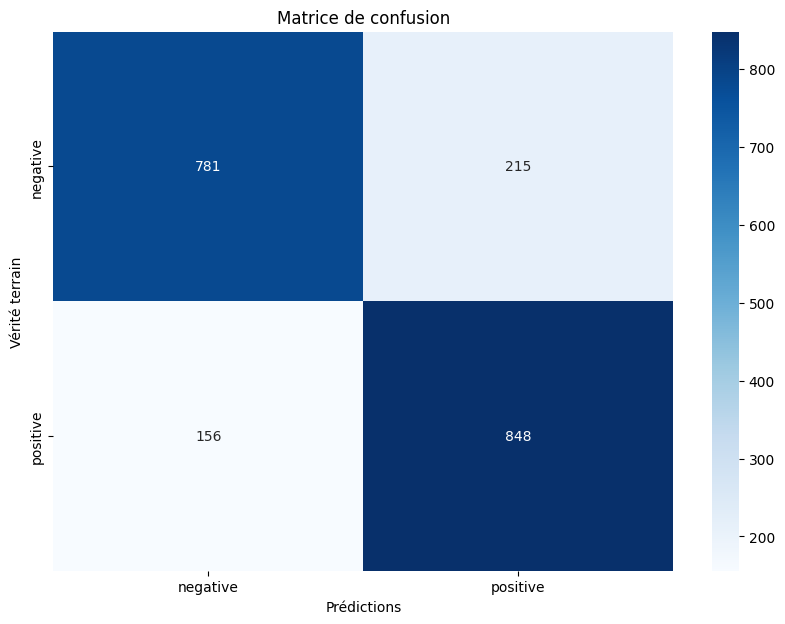

In [ ]:
from sklearn.metrics import  confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion')
plt.show()

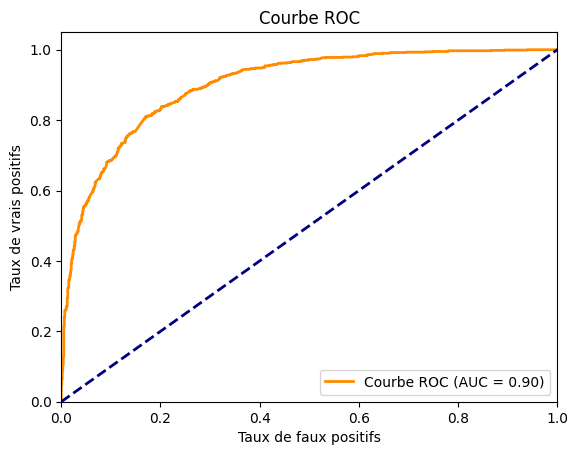

In [ ]:
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score


# Calculer les probabilités pour la courbe ROC
y_score = model.predict_proba(X_test)[:, 1]  # Probabilités de la classe positive

# Calculer la courbe ROC et l'AUC
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=model.classes_[1])
roc_auc = roc_auc_score(y_test, y_score)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Ligne diagonale pour une performance aléatoire
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

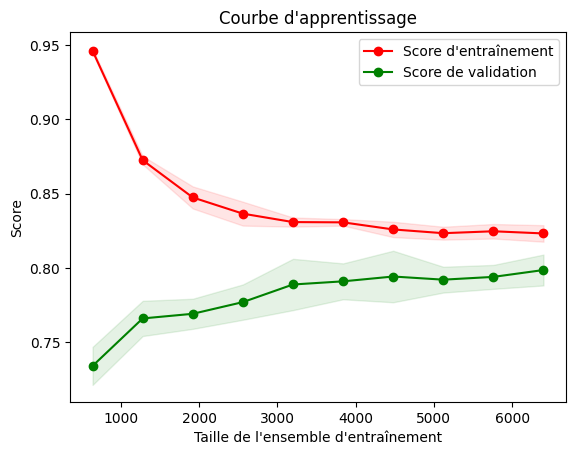

In [ ]:
from sklearn.model_selection import train_test_split, learning_curve
import matplotlib.pyplot as plt

# Tracer la courbe d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(estimator=model, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calculer les moyennes et les écarts-types des scores d'apprentissage
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validation")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Score")
plt.title("Courbe d'apprentissage")
plt.legend(loc="best")
plt.show()

#Modéle AdaBoost(10% test + 90%entrai)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


# Les étiquettes
y = data['sentiment']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Entraîner le modèle AdaBoost avec un classificateur de base DecisionTree
estimator = DecisionTreeClassifier(max_depth=1)  # Arbre de décision de profondeur 1
model = AdaBoostClassifier(estimator=estimator, n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# Prédictions du modèle sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Affichage des résultats
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.794
Precision: 0.7944054140740265
Recall: 0.794
F1-score: 0.7938845494867975


#Matrice de confusion

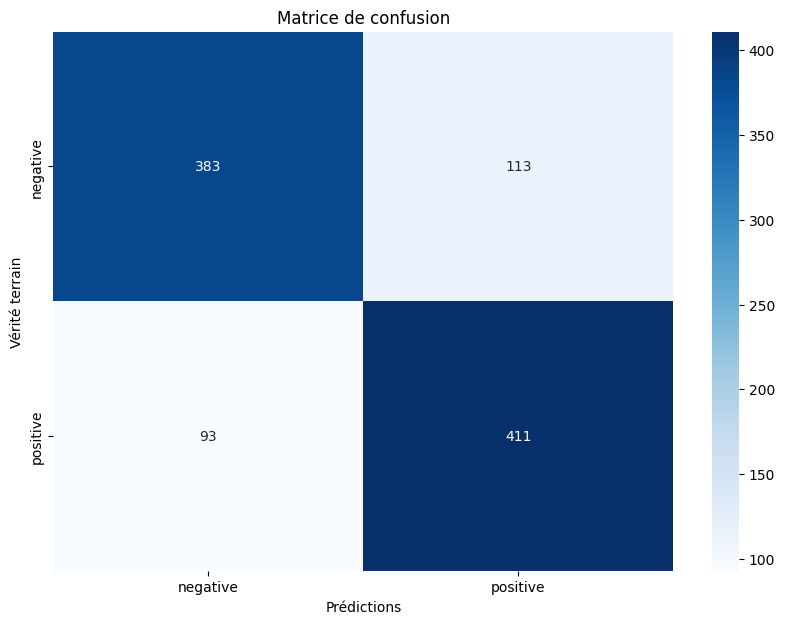

In [ ]:
from sklearn.metrics import  confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion')
plt.show()

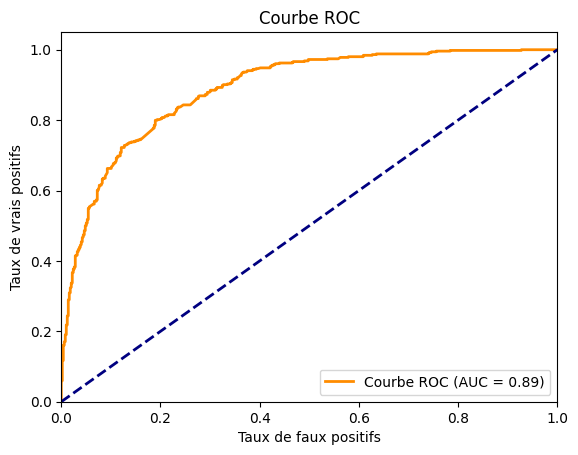

In [ ]:
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score


# Calculer les probabilités pour la courbe ROC
y_score = model.predict_proba(X_test)[:, 1]  # Probabilités de la classe positive

# Calculer la courbe ROC et l'AUC
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=model.classes_[1])
roc_auc = roc_auc_score(y_test, y_score)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Ligne diagonale pour une performance aléatoire
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

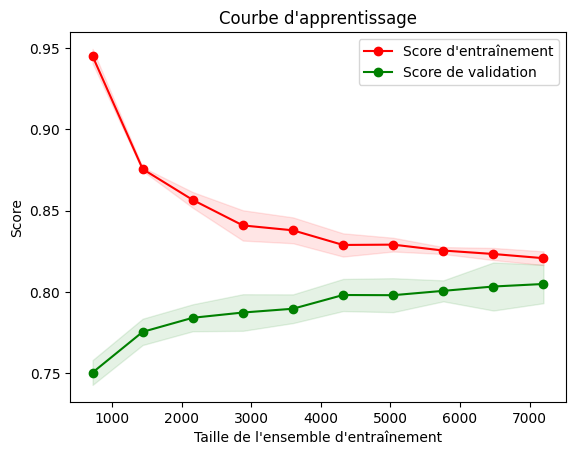

In [ ]:
from sklearn.model_selection import train_test_split, learning_curve
import matplotlib.pyplot as plt

# Tracer la courbe d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(estimator=model, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calculer les moyennes et les écarts-types des scores d'apprentissage
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validation")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Score")
plt.title("Courbe d'apprentissage")
plt.legend(loc="best")
plt.show()

#Modéle AdaBoost(30% test + 70%entrai)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


# Les étiquettes
y = data['sentiment']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraîner le modèle AdaBoost avec un classificateur de base DecisionTree
estimator = DecisionTreeClassifier(max_depth=1)  # Arbre de décision de profondeur 1
model = AdaBoostClassifier(estimator=estimator, n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# Prédictions du modèle sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Affichage des résultats
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.8056666666666666
Precision: 0.80767918437847
Recall: 0.8056666666666666
F1-score: 0.8052183549413819


#Matrice de confusion

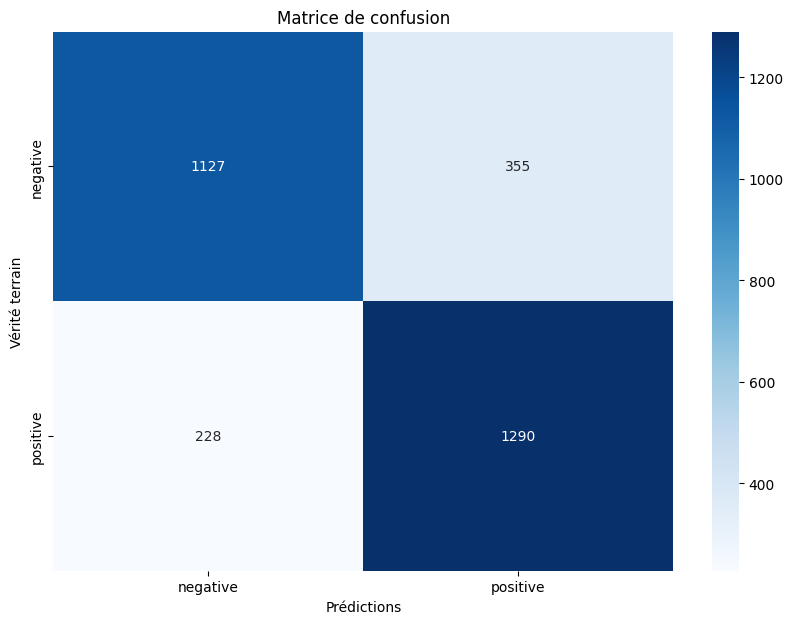

In [ ]:
from sklearn.metrics import  confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion')
plt.show()

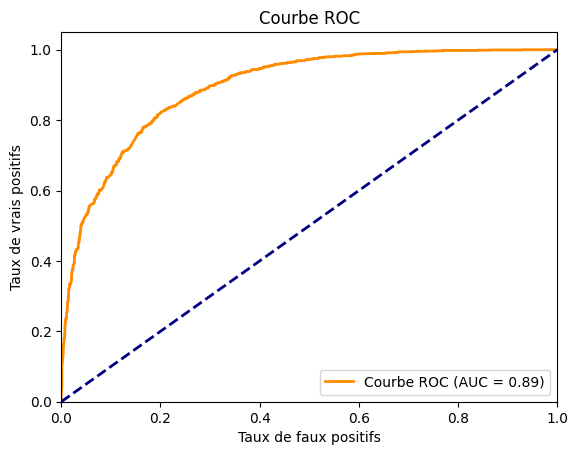

In [ ]:
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score


# Calculer les probabilités pour la courbe ROC
y_score = model.predict_proba(X_test)[:, 1]  # Probabilités de la classe positive

# Calculer la courbe ROC et l'AUC
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=model.classes_[1])
roc_auc = roc_auc_score(y_test, y_score)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Ligne diagonale pour une performance aléatoire
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

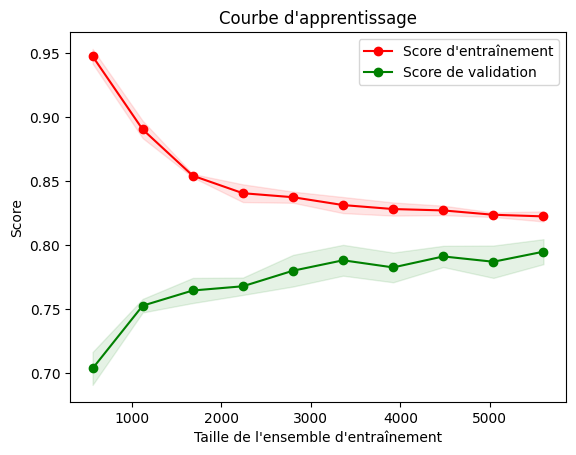

In [ ]:
from sklearn.model_selection import train_test_split, learning_curve
import matplotlib.pyplot as plt

# Tracer la courbe d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(estimator=model, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calculer les moyennes et les écarts-types des scores d'apprentissage
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validation")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Score")
plt.title("Courbe d'apprentissage")
plt.legend(loc="best")
plt.show()

#Modéle AdaBoost(40% test + 60%entrai)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


# Les étiquettes
y = data['sentiment']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Entraîner le modèle AdaBoost avec un classificateur de base DecisionTree
estimator = DecisionTreeClassifier(max_depth=1)  # Arbre de décision de profondeur 1
model = AdaBoostClassifier(estimator=estimator, n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# Prédictions du modèle sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Affichage des résultats
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.80125
Precision: 0.8028518299161795
Recall: 0.80125
F1-score: 0.801051924188748


#Matrice de confusion

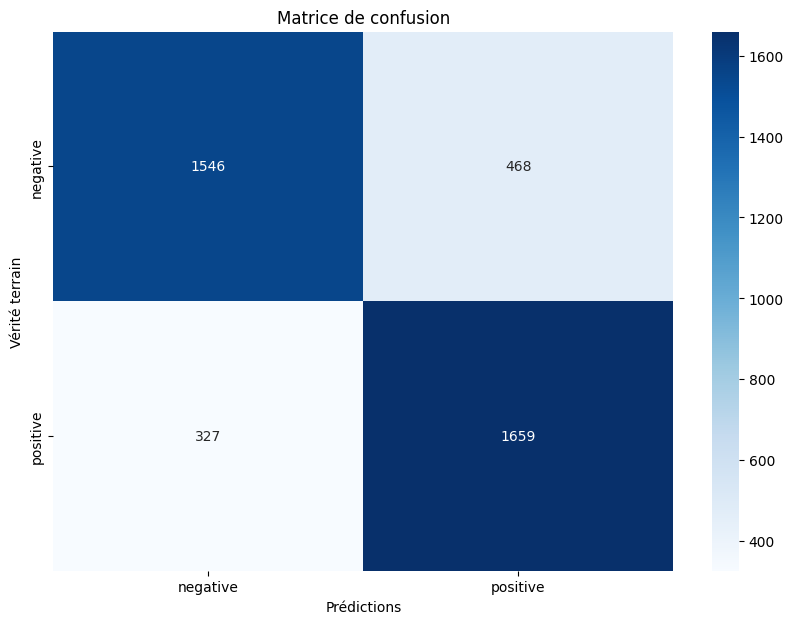

In [ ]:
from sklearn.metrics import  confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion')
plt.show()

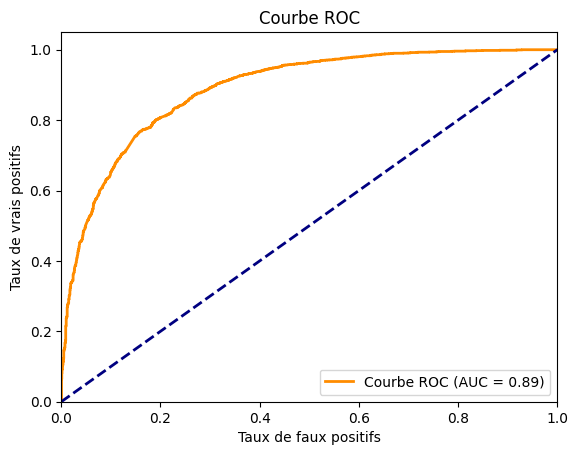

In [ ]:
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score


# Calculer les probabilités pour la courbe ROC
y_score = model.predict_proba(X_test)[:, 1]  # Probabilités de la classe positive

# Calculer la courbe ROC et l'AUC
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=model.classes_[1])
roc_auc = roc_auc_score(y_test, y_score)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Ligne diagonale pour une performance aléatoire
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

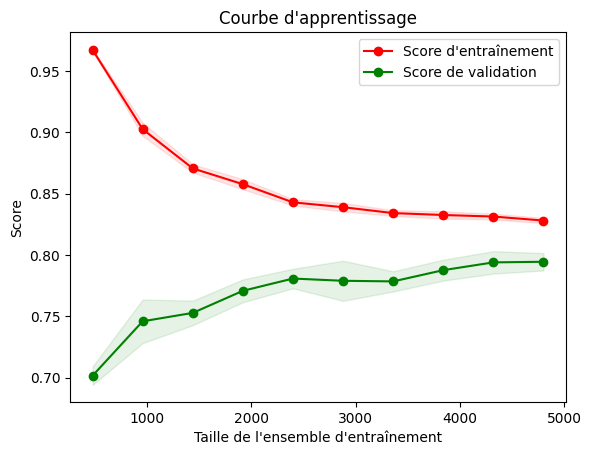

In [ ]:
from sklearn.model_selection import train_test_split, learning_curve
import matplotlib.pyplot as plt

# Tracer la courbe d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(estimator=model, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calculer les moyennes et les écarts-types des scores d'apprentissage
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validation")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Score")
plt.title("Courbe d'apprentissage")
plt.legend(loc="best")
plt.show()

#Modéle RNN(20% test + 80%entrai)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Données textuelles
textes = data['Cleanedreview']
etiquettes = data['sentiment']

# Encoder les étiquettes
label_encoder = LabelEncoder()
etiquettes = label_encoder.fit_transform(etiquettes)
etiquettes = to_categorical(etiquettes)

# Tokenization
max_mots = 10000  # Nous utilisons maintenant 10 000 mots
max_longueur = 100
tokenizer = Tokenizer(num_words=max_mots)
tokenizer.fit_on_texts(textes)
sequences = tokenizer.texts_to_sequences(textes)
sequences_padded = pad_sequences(sequences, maxlen=max_longueur)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(sequences_padded, etiquettes, test_size=0.2, random_state=42)

# Créer le modèle LSTM
model = Sequential()
model.add(Embedding(max_mots, 100, input_length=max_longueur))  # Nous utilisons la même dimension d'incorporation
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entraîner le modèle
batch_size = 64
epochs = 200

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2)

# Évaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Métriques
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')



Epoch 1/100
125/125 - 42s - loss: 0.4783 - accuracy: 0.7720 - val_loss: 0.3435 - val_accuracy: 0.8465 - 42s/epoch - 339ms/step
Epoch 2/100
125/125 - 38s - loss: 0.2235 - accuracy: 0.9166 - val_loss: 0.3357 - val_accuracy: 0.8595 - 38s/epoch - 300ms/step
Epoch 3/100
125/125 - 38s - loss: 0.1287 - accuracy: 0.9530 - val_loss: 0.4032 - val_accuracy: 0.8535 - 38s/epoch - 307ms/step
Epoch 4/100
125/125 - 40s - loss: 0.0929 - accuracy: 0.9679 - val_loss: 0.4514 - val_accuracy: 0.8565 - 40s/epoch - 319ms/step
Epoch 5/100
125/125 - 38s - loss: 0.0675 - accuracy: 0.9765 - val_loss: 0.6545 - val_accuracy: 0.8370 - 38s/epoch - 303ms/step
Epoch 6/100
125/125 - 39s - loss: 0.0410 - accuracy: 0.9852 - val_loss: 0.7203 - val_accuracy: 0.8345 - 39s/epoch - 314ms/step
Epoch 7/100
125/125 - 37s - loss: 0.0205 - accuracy: 0.9939 - val_loss: 1.0450 - val_accuracy: 0.8295 - 37s/epoch - 300ms/step
Epoch 8/100
125/125 - 37s - loss: 0.0194 - accuracy: 0.9933 - val_loss: 0.8026 - val_accuracy: 0.8275 - 37s/epo

In [ ]:
rapport = classification_report(y_test_classes, y_pred_classes, target_names=[str(c) for c in label_encoder.classes_])

print(f"Précision : {precision}")
print(f"Rappel : {recall}")
print(f"F1 Score : {f1}")
print("Rapport de classification :")
print(rapport)

Précision : 0.8245818826102311
Rappel : 0.8245
F1 Score : 0.8244813502109705
Rapport de classification :
              precision    recall  f1-score   support

    negative       0.83      0.82      0.82       996
    positive       0.82      0.83      0.83      1004

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



#Modéle RNN(10% test + 90%entrai)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Données textuelles
textes = data['Cleanedreview']
etiquettes = data['sentiment']

# Encoder les étiquettes
label_encoder = LabelEncoder()
etiquettes = label_encoder.fit_transform(etiquettes)
etiquettes = to_categorical(etiquettes)

# Tokenization
max_mots = 10000  # Nous utilisons maintenant 10 000 mots
max_longueur = 100
tokenizer = Tokenizer(num_words=max_mots)
tokenizer.fit_on_texts(textes)
sequences = tokenizer.texts_to_sequences(textes)
sequences_padded = pad_sequences(sequences, maxlen=max_longueur)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(sequences_padded, etiquettes, test_size=0.1, random_state=42)

# Créer le modèle LSTM
model = Sequential()
model.add(Embedding(max_mots, 100, input_length=max_longueur))  # Nous utilisons la même dimension d'incorporation
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entraîner le modèle
batch_size = 64
epochs = 100

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2)

# Évaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Métriques
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
rapport = classification_report(y_test_classes, y_pred_classes, target_names=[str(c) for c in label_encoder.classes_])

print(f"Précision : {precision}")
print(f"Rappel : {recall}")
print(f"F1 Score : {f1}")
print("Rapport de classification :")
print(rapport)


Epoch 1/100
141/141 - 79s - loss: 0.4627 - accuracy: 0.7658 - val_loss: 0.3539 - val_accuracy: 0.8460 - 79s/epoch - 560ms/step
Epoch 2/100
141/141 - 53s - loss: 0.2228 - accuracy: 0.9148 - val_loss: 0.3677 - val_accuracy: 0.8570 - 53s/epoch - 373ms/step
Epoch 3/100
141/141 - 50s - loss: 0.1364 - accuracy: 0.9511 - val_loss: 0.4677 - val_accuracy: 0.8430 - 50s/epoch - 351ms/step
Epoch 4/100
141/141 - 50s - loss: 0.0828 - accuracy: 0.9724 - val_loss: 0.5401 - val_accuracy: 0.8410 - 50s/epoch - 355ms/step
Epoch 5/100
141/141 - 50s - loss: 0.0512 - accuracy: 0.9821 - val_loss: 0.5531 - val_accuracy: 0.8410 - 50s/epoch - 358ms/step
Epoch 6/100
141/141 - 50s - loss: 0.0375 - accuracy: 0.9876 - val_loss: 0.6463 - val_accuracy: 0.8390 - 50s/epoch - 353ms/step
Epoch 7/100
141/141 - 50s - loss: 0.0261 - accuracy: 0.9916 - val_loss: 0.8230 - val_accuracy: 0.8400 - 50s/epoch - 353ms/step
Epoch 8/100
141/141 - 53s - loss: 0.0339 - accuracy: 0.9884 - val_loss: 0.7041 - val_accuracy: 0.8230 - 53s/epo

#Modéle RNN(30% test + 70%entrai)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Données textuelles
textes = data['Cleanedreview']
etiquettes = data['sentiment']

# Encoder les étiquettes
label_encoder = LabelEncoder()
etiquettes = label_encoder.fit_transform(etiquettes)
etiquettes = to_categorical(etiquettes)

# Tokenization
max_mots = 10000  # Nous utilisons maintenant 10 000 mots
max_longueur = 100
tokenizer = Tokenizer(num_words=max_mots)
tokenizer.fit_on_texts(textes)
sequences = tokenizer.texts_to_sequences(textes)
sequences_padded = pad_sequences(sequences, maxlen=max_longueur)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(sequences_padded, etiquettes, test_size=0.3, random_state=42)

# Créer le modèle LSTM
model = Sequential()
model.add(Embedding(max_mots, 100, input_length=max_longueur))  # Nous utilisons la même dimension d'incorporation
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entraîner le modèle
batch_size = 64
epochs = 100

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2)

# Évaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Métriques
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
rapport = classification_report(y_test_classes, y_pred_classes, target_names=[str(c) for c in label_encoder.classes_])

print(f"Précision : {precision}")
print(f"Rappel : {recall}")
print(f"F1 Score : {f1}")
print("Rapport de classification :")
print(rapport)


Epoch 1/100
110/110 - 70s - loss: 0.4964 - accuracy: 0.7407 - val_loss: 0.3491 - val_accuracy: 0.8470 - 70s/epoch - 639ms/step
Epoch 2/100
110/110 - 42s - loss: 0.2290 - accuracy: 0.9111 - val_loss: 0.3591 - val_accuracy: 0.8520 - 42s/epoch - 380ms/step
Epoch 3/100
110/110 - 38s - loss: 0.1218 - accuracy: 0.9591 - val_loss: 0.4783 - val_accuracy: 0.8430 - 38s/epoch - 348ms/step
Epoch 4/100
110/110 - 41s - loss: 0.0867 - accuracy: 0.9730 - val_loss: 0.4664 - val_accuracy: 0.8440 - 41s/epoch - 376ms/step
Epoch 5/100
110/110 - 37s - loss: 0.0476 - accuracy: 0.9843 - val_loss: 0.5786 - val_accuracy: 0.8310 - 37s/epoch - 340ms/step
Epoch 6/100
110/110 - 40s - loss: 0.0375 - accuracy: 0.9883 - val_loss: 0.6830 - val_accuracy: 0.8400 - 40s/epoch - 361ms/step
Epoch 7/100
110/110 - 37s - loss: 0.0297 - accuracy: 0.9894 - val_loss: 0.9197 - val_accuracy: 0.8303 - 37s/epoch - 337ms/step
Epoch 8/100
110/110 - 39s - loss: 0.0199 - accuracy: 0.9941 - val_loss: 0.9636 - val_accuracy: 0.8330 - 39s/epo

#Modéle RNN(40% test + 60%entrai)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Données textuelles
textes = data['Cleanedreview']
etiquettes = data['sentiment']

# Encoder les étiquettes
label_encoder = LabelEncoder()
etiquettes = label_encoder.fit_transform(etiquettes)
etiquettes = to_categorical(etiquettes)

# Tokenization
max_mots = 10000  # Nous utilisons maintenant 10 000 mots
max_longueur = 100
tokenizer = Tokenizer(num_words=max_mots)
tokenizer.fit_on_texts(textes)
sequences = tokenizer.texts_to_sequences(textes)
sequences_padded = pad_sequences(sequences, maxlen=max_longueur)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(sequences_padded, etiquettes, test_size=0.4, random_state=42)

# Créer le modèle LSTM
model = Sequential()
model.add(Embedding(max_mots, 100, input_length=max_longueur))  # Nous utilisons la même dimension d'incorporation
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entraîner le modèle
batch_size = 64
epochs = 100

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2)

# Évaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Métriques
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
rapport = classification_report(y_test_classes, y_pred_classes, target_names=[str(c) for c in label_encoder.classes_])

print(f"Précision : {precision}")
print(f"Rappel : {recall}")
print(f"F1 Score : {f1}")
print("Rapport de classification :")
print(rapport)


Epoch 1/100
94/94 - 41s - loss: 0.5818 - accuracy: 0.6867 - val_loss: 0.3505 - val_accuracy: 0.8505 - 41s/epoch - 439ms/step
Epoch 2/100
94/94 - 33s - loss: 0.2571 - accuracy: 0.9045 - val_loss: 0.3481 - val_accuracy: 0.8522 - 33s/epoch - 354ms/step
Epoch 3/100
94/94 - 33s - loss: 0.1365 - accuracy: 0.9547 - val_loss: 0.4152 - val_accuracy: 0.8508 - 33s/epoch - 354ms/step
Epoch 4/100
94/94 - 38s - loss: 0.0688 - accuracy: 0.9792 - val_loss: 0.4642 - val_accuracy: 0.8355 - 38s/epoch - 401ms/step
Epoch 5/100
94/94 - 35s - loss: 0.0466 - accuracy: 0.9860 - val_loss: 0.5828 - val_accuracy: 0.8390 - 35s/epoch - 368ms/step
Epoch 6/100
94/94 - 33s - loss: 0.0271 - accuracy: 0.9932 - val_loss: 0.7916 - val_accuracy: 0.8347 - 33s/epoch - 352ms/step
Epoch 7/100
94/94 - 36s - loss: 0.0256 - accuracy: 0.9912 - val_loss: 0.9392 - val_accuracy: 0.8202 - 36s/epoch - 378ms/step
Epoch 8/100
94/94 - 34s - loss: 0.0222 - accuracy: 0.9932 - val_loss: 0.8546 - val_accuracy: 0.8257 - 34s/epoch - 359ms/step
